# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between EastEnders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the EastEnders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **50 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
from scipy.sparse import hstack

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from copy import deepcopy

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [49]:
# Load in training data and display in pandas dataframe
train_path = 'training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path = 'val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# set the parameters of the vectorisation
parameters = {'techniques': ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation'], 'extra_features': ['gender'], 'context': False}

# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [50]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count=300, gend=False,
                                             context=parameters['context']):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them

    Improve this for Q3

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {} if not gend else {'MALE':0, 'FEMALE':0}

    # Generate a mapping from scenes to the names of all the characters in the scene
    if context:
      scene_characters = {}
      for episode, scene in set(zip(df.Episode, df.Scene)):
        scene_context = []
        scene_characters[(episode, scene)] = \
        df[(df.Episode == episode) & (df.Scene == scene)].Character_name.unique()

    for line, name, gender, scene in zip(df.Line, df.Character_name,
                                         df.Gender, zip(df.Episode, df.Scene)):
        # Remove the empty lines
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not gend:
          if not name in character_docs.keys():
              character_docs[name] = ""
              character_line_count[name] = 0
          if character_line_count[name]==max_line_count:
              continue
          character_docs[name] += str(line) + " _EOL_ "  # adding an end-of-line token
          character_line_count[name]+=1

          # Adding each line to all the characters in the scene as context
          if context:
            for n in scene_characters[scene]:
              if n==name: # the current line was already added to the character who spoke it
                continue
              if not n in character_docs.keys():
                character_docs[n] = ""
                character_line_count[n] = 0
              if character_line_count[n]==max_line_count:
                continue
              character_docs[n] += str(line) + " _EOL_ "
              character_line_count[n]+=1
        else:
          character_docs[line] = gender # create dataset for gender classifier
    if not gend:
      print("lines per character", character_line_count)

    return character_docs

In [51]:
# Print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
gender_docs = create_character_document_from_dataframe(train_data, gend=True, context=False)
print('Num. Characters: ', len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ', len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079


In [52]:
def pre_process(character_text, tech = parameters['techniques'],
                context = parameters['context'],
                eol='eol_removal' not in parameters['techniques']):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Initially just a tokenization on white space. Improve this for Q1.

    ::character_text:: a string with all of one character's lines
    ::techniques:: a list of strings indicating which pre-processing techniques to use
    ::context:: a boolean indicating whether to add context features
    """
    # Initialisation of lemmatiser, stopwords, and common contractions
    lemmatiser = nltk.WordNetLemmatizer()
    stemmer = nltk.stem.PorterStemmer()
    stopwords = set(nltk.corpus.stopwords.words('english'))

    text = character_text
    if not eol: # removes _EOL_ tokens as they provide no information without order info
      text = re.sub(r"(_EOL_)", r"", text)
    if 'punct_separation' in tech:
      text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
      text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    tokens = text.split() # text splitting
    if 'punct_removal' in tech:
      tokens = [t for t in tokens if t not in '!"#$%&’()*+,-./:;<=>?@[\]^_{|}~`\''] # punctuation removal
    if 'lowercase' in tech:
      tokens = [t.lower() for t in tokens] # lowercase normalisation
    if 'stopword_removal' in tech:
      tokens = [t for t in tokens if t not in stopwords] # stopword removal
    if 'lemmatisation' in tech:
      tokens = [lemmatiser.lemmatize(t) for t in tokens] # lemmatisation

    # Basic extra features from Q2 added here for convenience
    if 'bigrams' in tech: # adding bigrams
      tokens += [' '.join(b) for b in list(nltk.ngrams(tokens, 2))]
    if 'POS' in tech: # adding tokens combined with their POS tags
      tokens += ['_'.join(t) for t in nltk.pos_tag(tokens)]
    if 'POS_counts' in tech: # adding count of each POS tag
      tokens += [t[1] for t in nltk.pos_tag(tokens)]

    return tokens

In [53]:
# Create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Create dataset for gender classifier
gender_y = [gender for gender in gender_docs.values()]
gender_X = []
current_line = []
full = pre_process(" _EOL_ ".join(list(gender_docs)) + " _EOL_ ", context=False, eol=True) # preprocess the whole corpus at once for efficiency
for word in full:
  if word == "_eol_":
    gender_X.append(current_line)
    current_line = []
  else:
    current_line.append(word)

# Train gender classifier
gender_classifier = LinearSVC()
vectoriser = TfidfVectorizer()
gender_X_joined = [" ".join(line) for line in gender_X]
gender_classifier.fit(vectoriser.fit_transform(gender_X_joined), gender_y)

LinearSVC()

In [54]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.


    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    counts = Counter(character_doc)  # a simple count as the exact values won't be used
    counts = dict(counts)

    if 'gender' in extra_features: # add gender-based classifier to the features
      character_doc_joined = " ".join(character_doc)
      pred = gender_classifier.predict(vectoriser.transform([character_doc_joined]))[0]
      pred = 0.1 if pred == 'FEMALE' else 0
      counts['gender'] = pred

    if 'avg_length' in extra_features: # add normalised average line length
      counts['avg_length'] = 0.05*(len(character_doc)-mu)/sigma # z-normalisation

    if 'pos_score' and 'neg_score' in extra_features: # add sentiment information
      # Convert pos tag to format used by wordnet lemmatizer
      def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return None

      # Get positivity and negativity scores from sentiwordnet for a given word and its POS tag
      def get_sentiwordnet_scores(word, pos_tag):
          wn_pos = get_wordnet_pos(pos_tag)
          if wn_pos is None:
              return 0, 0

          #Llemmatize the word and look it up in sentiwordnet
          lemmatizer = nltk.WordNetLemmatizer()
          lemma = lemmatizer.lemmatize(word, pos=wn_pos)
          synsets = list(nltk.corpus.sentiwordnet.senti_synsets(lemma, wn_pos))
          if not synsets:
              return 0, 0

          # Average the scores across all synsets for the word
          pos_score = sum(synset.pos_score() for synset in synsets) / len(synsets)
          neg_score = sum(synset.neg_score() for synset in synsets) / len(synsets)
          return pos_score, neg_score

      # Calculate positivity and negativity scores using sentiwordnet
      pos_total, neg_total = 0, 0
      tagged_tokens = nltk.pos_tag(character_doc)
      for word, tag in tagged_tokens:
          pos_score, neg_score = get_sentiwordnet_scores(word, tag)
          pos_total += pos_score
          neg_total += neg_score
      counts['pos_score'] = pos_total*0.001
      counts['neg_score'] = neg_total*0.001

    return counts

In [55]:
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_vectoriser = TfidfVectorizer() # instantiate TfidfVectorizer class
extra = parameters['extra_features'] # extra features

def create_document_matrix_from_corpus(corpus, fitting=False, ef=extra):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    global mu, sigma, selected_columns

    if 'avg_length' in ef:
      # Compute mean and std for z-normalisation
      mu = np.mean([len(corpus[i][1]) for i in range(len(corpus))])
      sigma = np.std([len(corpus[i][1]) for i in range(len(corpus))])

    feature_dict_list = [to_feature_vector_dictionary(doc, ef) for name, doc in corpus]
    docs_joined = [" ".join(doc) for _, doc in corpus]

    # TF-IDF Transformation
    if fitting:
        doc_feature_matrix = tfidf_vectoriser.fit_transform(docs_joined)

        # Handle k-best feature selection
        if any('k-best' in s for s in ef):
            # Extract the percentage
            prcnt = int(ef[['k-best' in s for s in ef].index(True)].split('_')[1])
            means = np.array(doc_feature_matrix.mean(axis=0)).flatten()
            k = int((prcnt / 100) * len(means))  # compute number of features to keep
            selected_columns = np.argsort(means)[-k:]  # select top k
            doc_feature_matrix = doc_feature_matrix[:, selected_columns]
    else:
        doc_feature_matrix = tfidf_vectoriser.transform(docs_joined)
        if 'selected_columns' in globals():
            doc_feature_matrix = doc_feature_matrix[:, selected_columns]  # apply same selection
            del globals()['selected_columns'] # delete selected_columns from the global scope for reusibility

    # Concatenate extra features
    ef = [p for p in ef if 'k-best' not in p]
    doc_feature_matrix = hstack((doc_feature_matrix, np.array([[fd[key] for key in ef] for fd in feature_dict_list])))

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [56]:
training_feature_matrix

<16x8670 sparse matrix of type '<class 'numpy.float64'>'
	with 21947 stored elements in COOrdinate format>

In [57]:
# Get the validation data- only 50 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# Create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num. Characters:  16 

OTHER Num of Words:  463
HEATHER Num of Words:  514
TANYA Num of Words:  487
JACK Num of Words:  491
RONNIE Num of Words:  376
JANE Num of Words:  596
STACEY Num of Words:  508
SEAN Num of Words:  513
PHIL Num of Words:  366
SHIRLEY Num of Words:  583
ROXY Num of Words:  327
IAN Num of Words:  662
MINTY Num of Words:  603
CHRISTIAN Num of Words:  347
CLARE Num of Words:  449
MAX Num of Words:  565
total words 7850


In [58]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [59]:
val_feature_matrix

<16x8670 sparse matrix of type '<class 'numpy.float64'>'
	with 4241 stored elements in COOrdinate format>

In [60]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # Compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [61]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # Compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # Get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # Display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [62]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    global cm, labels # globalise variables for later use
    # Add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [63]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.125
mean cosine similarity 0.38350340776771275
14 correct out of 16 / accuracy: 0.875


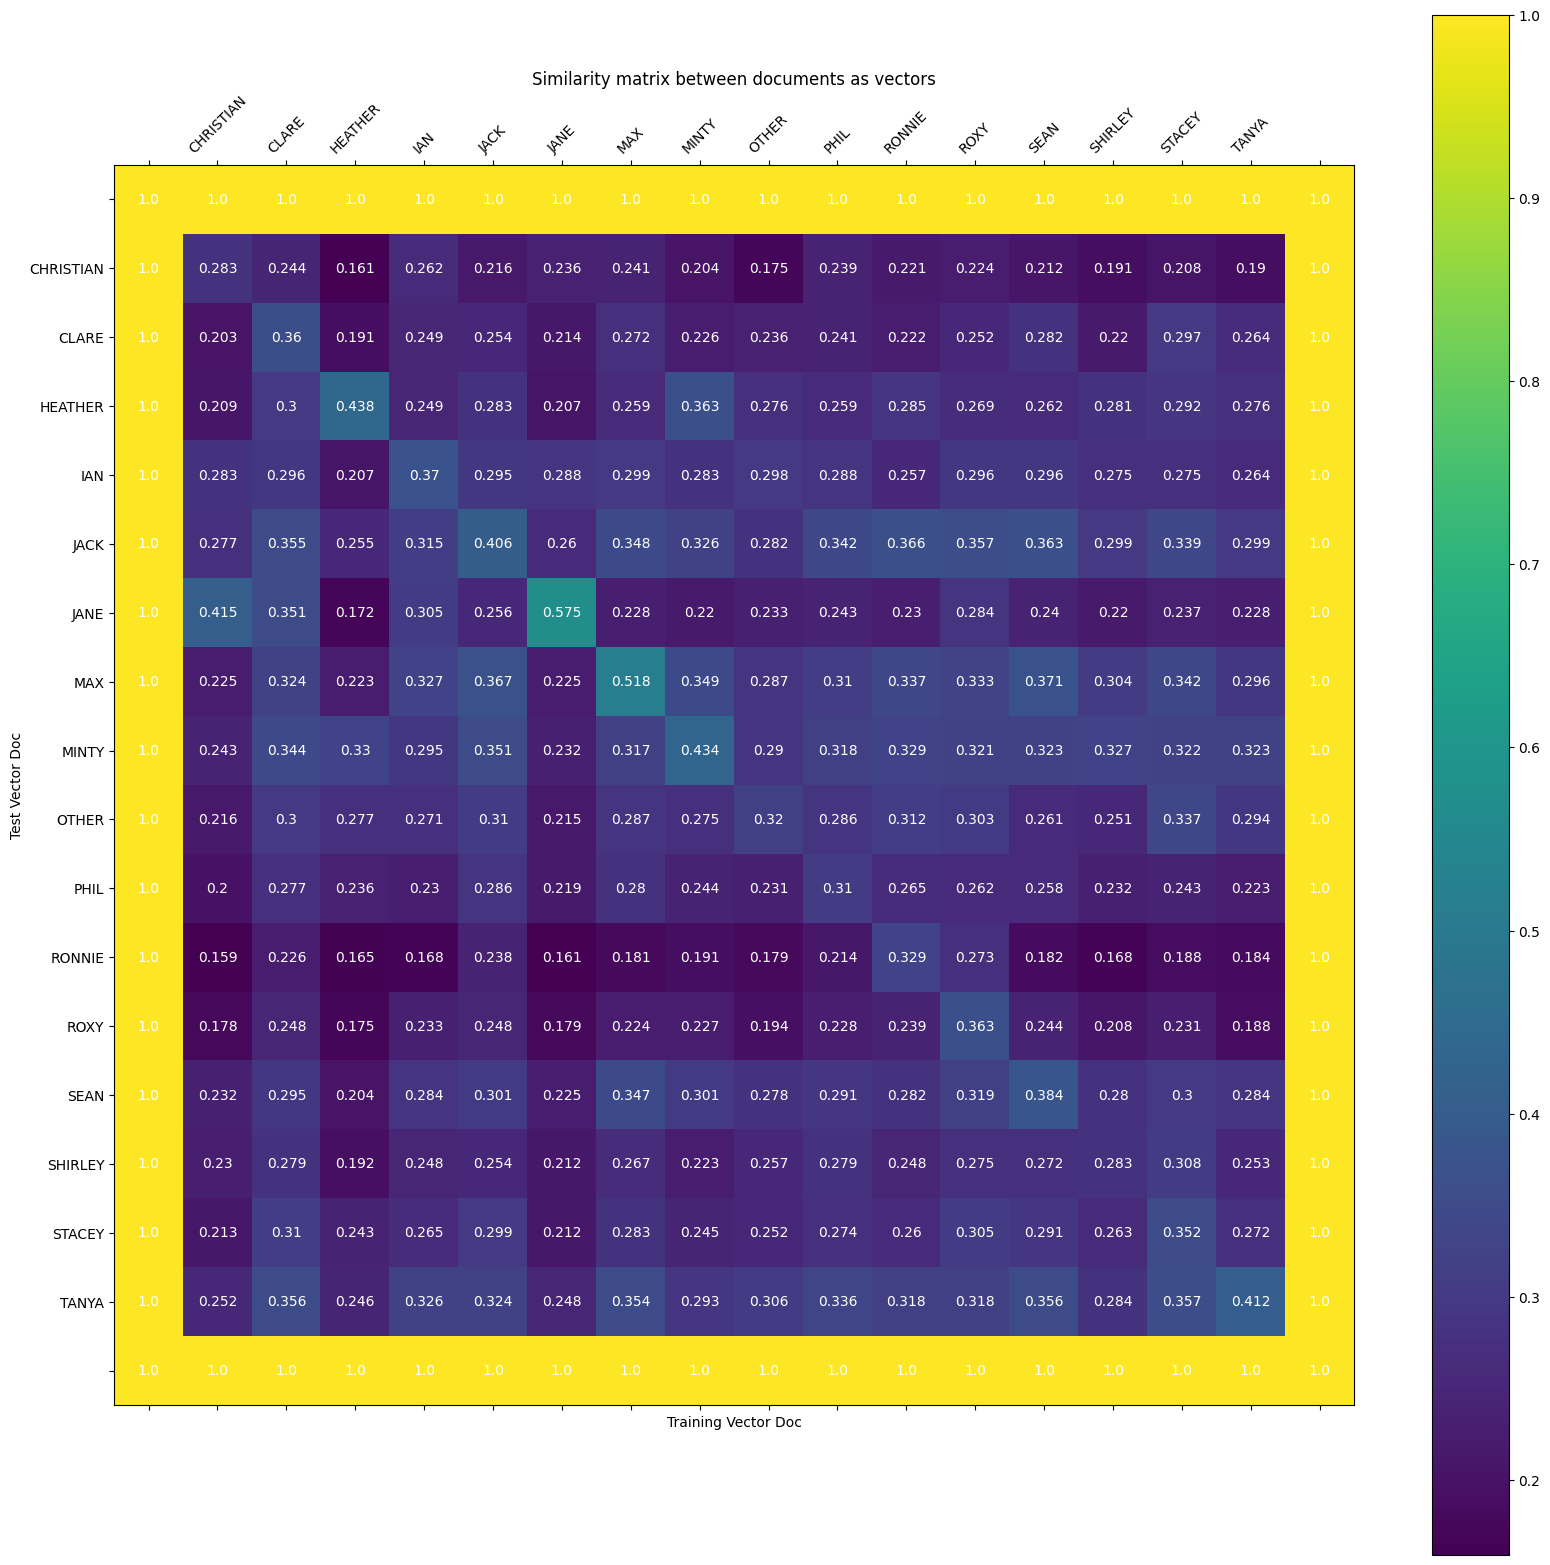

In [67]:
plot_heat_map_similarity(df)

In [19]:
### GRID SEARCH
original_params = deepcopy(parameters) # store original parameters

# Function to get a reconfigured parameter dictionary from configuration index
def get_reconfig(search_space, i):
  n = len(search_space)
  config = [(i >> j) & 1 == 1 for j in range(n)] # boolean array representing each configuration of parameters
  new = deepcopy(parameters) # created a copy of the original parameters to be reconfigured
  for j in range(n):
    # Change the appropriate parameter corresponding to the boolean array element
    if search_space[j] == 'context':
      new['context'] = config[j]
    elif search_space[j] == 'sentiment':
      if config[j]:
        new['extra_features'] = list(set(new['extra_features'] + ['pos_score', 'neg_score']))
      else:
        new['extra_features'] = [p for p in new['extra_features'] if p not in ['pos_score', 'neg_score']]
    elif search_space[j] in ['gender', 'avg_length'] or 'k-best' in search_space[j]:
      if config[j]:
        new['extra_features'] = list(set(new['extra_features'] + [search_space[j]]))
        if 'k-best' in search_space[j]:
          new['extra_features'] = [p for p in new['extra_features'] if p == search_space[j] or 'k-best' not in p]
      else:
        new['extra_features'] = [p for p in new['extra_features'] if p != search_space[j]]
    elif search_space[j] in ['punct_separation', 'punct_removal', 'lowercase',
            'stopword_removal', 'lemmatisation', 'bigrams', 'POS', 'POS_counts', 'eol_removal']:
      if config[j]:
        new['techniques'] = list(set(new['techniques'] + [search_space[j]]))
      else:
        new['techniques'] = [p for p in new['techniques'] if p != search_space[j]]

    # Raise error if the search space contains an unexpected parameter
    else: raise Exception(f"Invalid parameter {search_space[j]}")

  return new

# General grid search function
def grid_search(search_space):
  results = {}
  # Initialise cached results of large variables for computational efficiency
  cache = {('cd', original_params['context']):(train_character_docs, val_character_docs),
           ('c', tuple(sorted(original_params['techniques'])+[original_params['context']])):
           (training_corpus, train_labels, val_corpus, val_labels)}
  for i in range(2**len(search_space)): # 2^(#binary parameters) possible configurations
    new = get_reconfig(search_space, i)
    cd_key = ('cd', new['context']) # create key to access cached results
    c_key = ('c', tuple(sorted(new['techniques'])+[new['context']]))
    if cd_key not in cache: # create new variables and cache the results if they aren't already
      tcd = create_character_document_from_dataframe(train_data, max_line_count=300, context=new['context'])
      vcd = create_character_document_from_dataframe(val_data, max_line_count=50, context=new['context'])
      cache[cd_key] = (tcd, vcd)
    else:
      tcd, vcd = cache[cd_key]
    if c_key not in cache: # create new variables and cache the results if they aren't already
      eol = 'eol_removal' not in new['techniques']
      tc = [(name, pre_process(doc, tech=new['techniques'], context=new['context'], eol=eol)) for name, doc in sorted(tcd.items())]
      tl = [name for name, doc in tc]
      vc = [(name, pre_process(doc, tech=new['techniques'], context=new['context'], eol=eol)) for name, doc in sorted(vcd.items())]
      vl = [name for name, doc in vc]
      cache[c_key] = (tc, tl, vc, vl)
    else:
      tc, tl, vc, vl = cache[c_key]
    # No need to cache feature matrices since they are guaranteed to be different for every iteration
    tfm = create_document_matrix_from_corpus(tc, fitting=True, ef=new['extra_features'])
    vfm = create_document_matrix_from_corpus(vc, fitting=False, ef=new['extra_features'])

    # Flatten the reconfigured parameters into a list to prepare for conversion into a tuple
    new.update({'context':['context']}) if new['context'] else new.pop('context')
    params_flat = [p for lst in new.values() for p in lst]
    print(f"Config: {params_flat}")

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(tfm, vfm, tl, vl)
    results[tuple(params_flat)] = [mean_rank, mean_cosine_simliarity, acc] # convert into tuple for hashability
  return results

In [20]:
# Grid search for Q3
results = grid_search(['context'])
params_flat = sorted(results.items(), key=lambda x: x[1][0])[0][0]
parameters = {'techniques': [t for t in params_flat if t not in ['context', 'gender', 'avg_length', 'pos_score', 'neg_score']],
              'extra_features': [t for t in params_flat if t in ['gender', 'avg_length', 'pos_score', 'neg_score']],
              'context': True if 'context' in params_flat else False}

Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation', 'gender']
mean rank 1.125
mean cosine similarity 0.38350340776771275
14 correct out of 16 / accuracy: 0.875
lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
lines per character {'OTHER': 50, 'HEATHER': 50, 'TANYA': 50, 'JACK': 50, 'RONNIE': 50, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 50, 'SHIRLEY': 50, 'ROXY': 50, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 50, 'CLARE': 45, 'MAX': 50}
Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation', 'gender', 'context']
mean rank 2.75
mean cosine similarity 0.36789111930048995
9 correct out of 16 / accuracy: 0.5625


In [21]:
# Grid search for Q1
results.update(grid_search(['punct_separation', 'punct_removal', 'lowercase',
              'stopword_removal', 'lemmatisation', 'POS', 'bigrams', 'eol_removal']))
params_flat = sorted(results.items(), key=lambda x: x[1][0])[0][0]
parameters = {'techniques': [t for t in params_flat if t not in ['context', 'gender', 'avg_length', 'pos_score', 'neg_score']],
              'extra_features': [t for t in params_flat if t in ['gender', 'avg_length', 'pos_score', 'neg_score']],
              'context': True if 'context' in params_flat else False}

Config: ['gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['punct_separation', 'gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['punct_removal', 'gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['punct_removal', 'punct_separation', 'gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['lowercase', 'gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['punct_separation', 'lowercase', 'gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['punct_removal', 'lowercase', 'gender']
mean rank 2.8125
mean cosine similarity 0.8782849734274619
9 correct out of 16 / accuracy: 0.5625
Config: ['punct_removal', 'punc

In [22]:
# Grid search for Q2
results.update(grid_search(['gender', 'avg_length', 'sentiment', 'k-best_30', 'k-best_90']))
params_flat = sorted(results.items(), key=lambda x: x[1][0])[0][0]
parameters = {'techniques': [t for t in params_flat if t not in ['context', 'gender', 'avg_length', 'pos_score', 'neg_score']],
              'extra_features': [t for t in params_flat if t in ['gender', 'avg_length', 'pos_score', 'neg_score']],
              'context': True if 'context' in params_flat else False}

Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation']
mean rank 1.1875
mean cosine similarity 0.3805352767623882
14 correct out of 16 / accuracy: 0.875
Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation', 'gender']
mean rank 1.125
mean cosine similarity 0.38350340776771275
14 correct out of 16 / accuracy: 0.875
Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation', 'avg_length']
mean rank 1.1875
mean cosine similarity 0.3802435600792706
14 correct out of 16 / accuracy: 0.875
Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation', 'gender', 'avg_length']
mean rank 1.125
mean cosine similarity 0.3832098618712486
14 correct out of 16 / accuracy: 0.875
Config: ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation', 'neg_score', 'pos_score']
mean rank 1.1875
mean cosine similarity 0.3802031900332957
14 correct out of 16 / accuracy: 0.875
Config: ['eol_rem

In [23]:
print(f"Best parameters: {parameters}")
print(f"Best mean rank: {sorted(results.items(), key=lambda x: x[1][0])[0][1][0]}")
print(f"Best accuracy: {sorted(results.items(), key=lambda x: x[1][2], reverse=True)[0][1][2]}")

Best parameters: {'techniques': ['eol_removal', 'lowercase', 'stopword_removal', 'POS', 'punct_separation'], 'extra_features': ['gender'], 'context': False}
Best mean rank: 1.125
Best accuracy: 0.9375


In [96]:
# Q5
extremes = {}
labels_clean = labels[1:-1]
for i in range(len(labels_clean)):
  character = labels_clean[i] # get character name
  extremes[character] = [] # initialise list of characters with lowest and highest similarity
  values = np.array(cm)[1:-1, i+1] # remove padding
  sorted_values = np.sort(values) # sort the values
  max_value = sorted_values[-1] # retrieve maximum value
  max_char = labels_clean[np.where(values == max_value)[0][0]] # get corresponding character
  if max_char == character: # cannot be the character themselves
    max_value = sorted_values[-2] # retrieve second highest value
    max_char = labels_clean[np.where(values == max_value)[0][0]] # get corresponding character
  min_value = sorted_values[0] # retrieve minimum value
  min_char = labels_clean[np.where(values == min_value)[0][0]] # get corresponding character
  extremes[character].append(max_char) # append maximum value
  extremes[character].append(min_char) # append minimum value

for character in extremes:
  print(f"For {character}")
  print(f"Most similar character: {extremes[character][0]}, Least similar character: {extremes[character][1]}")

For CHRISTIAN
Most similar character: JANE, Least similar character: RONNIE
For CLARE
Most similar character: TANYA, Least similar character: RONNIE
For HEATHER
Most similar character: MINTY, Least similar character: CHRISTIAN
For IAN
Most similar character: MAX, Least similar character: RONNIE
For JACK
Most similar character: MAX, Least similar character: CHRISTIAN
For JANE
Most similar character: IAN, Least similar character: RONNIE
For MAX
Most similar character: TANYA, Least similar character: RONNIE
For MINTY
Most similar character: HEATHER, Least similar character: RONNIE
For OTHER
Most similar character: TANYA, Least similar character: CHRISTIAN
For PHIL
Most similar character: JACK, Least similar character: RONNIE
For RONNIE
Most similar character: JACK, Least similar character: CHRISTIAN
For ROXY
Most similar character: JACK, Least similar character: CHRISTIAN
For SEAN
Most similar character: MAX, Least similar character: RONNIE
For SHIRLEY
Most similar character: MINTY, Least

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 50 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially, the code in this template achieves a mean rank of **4.3**  and accuracy of **0.25** on the test set and a mean rank of **3.6** and accuracy of **0.31** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html.

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 50 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [24]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, ef=parameters['extra_features'])

# get the test data using 50 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=50)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079
lines per character {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}
Num. Characters:  

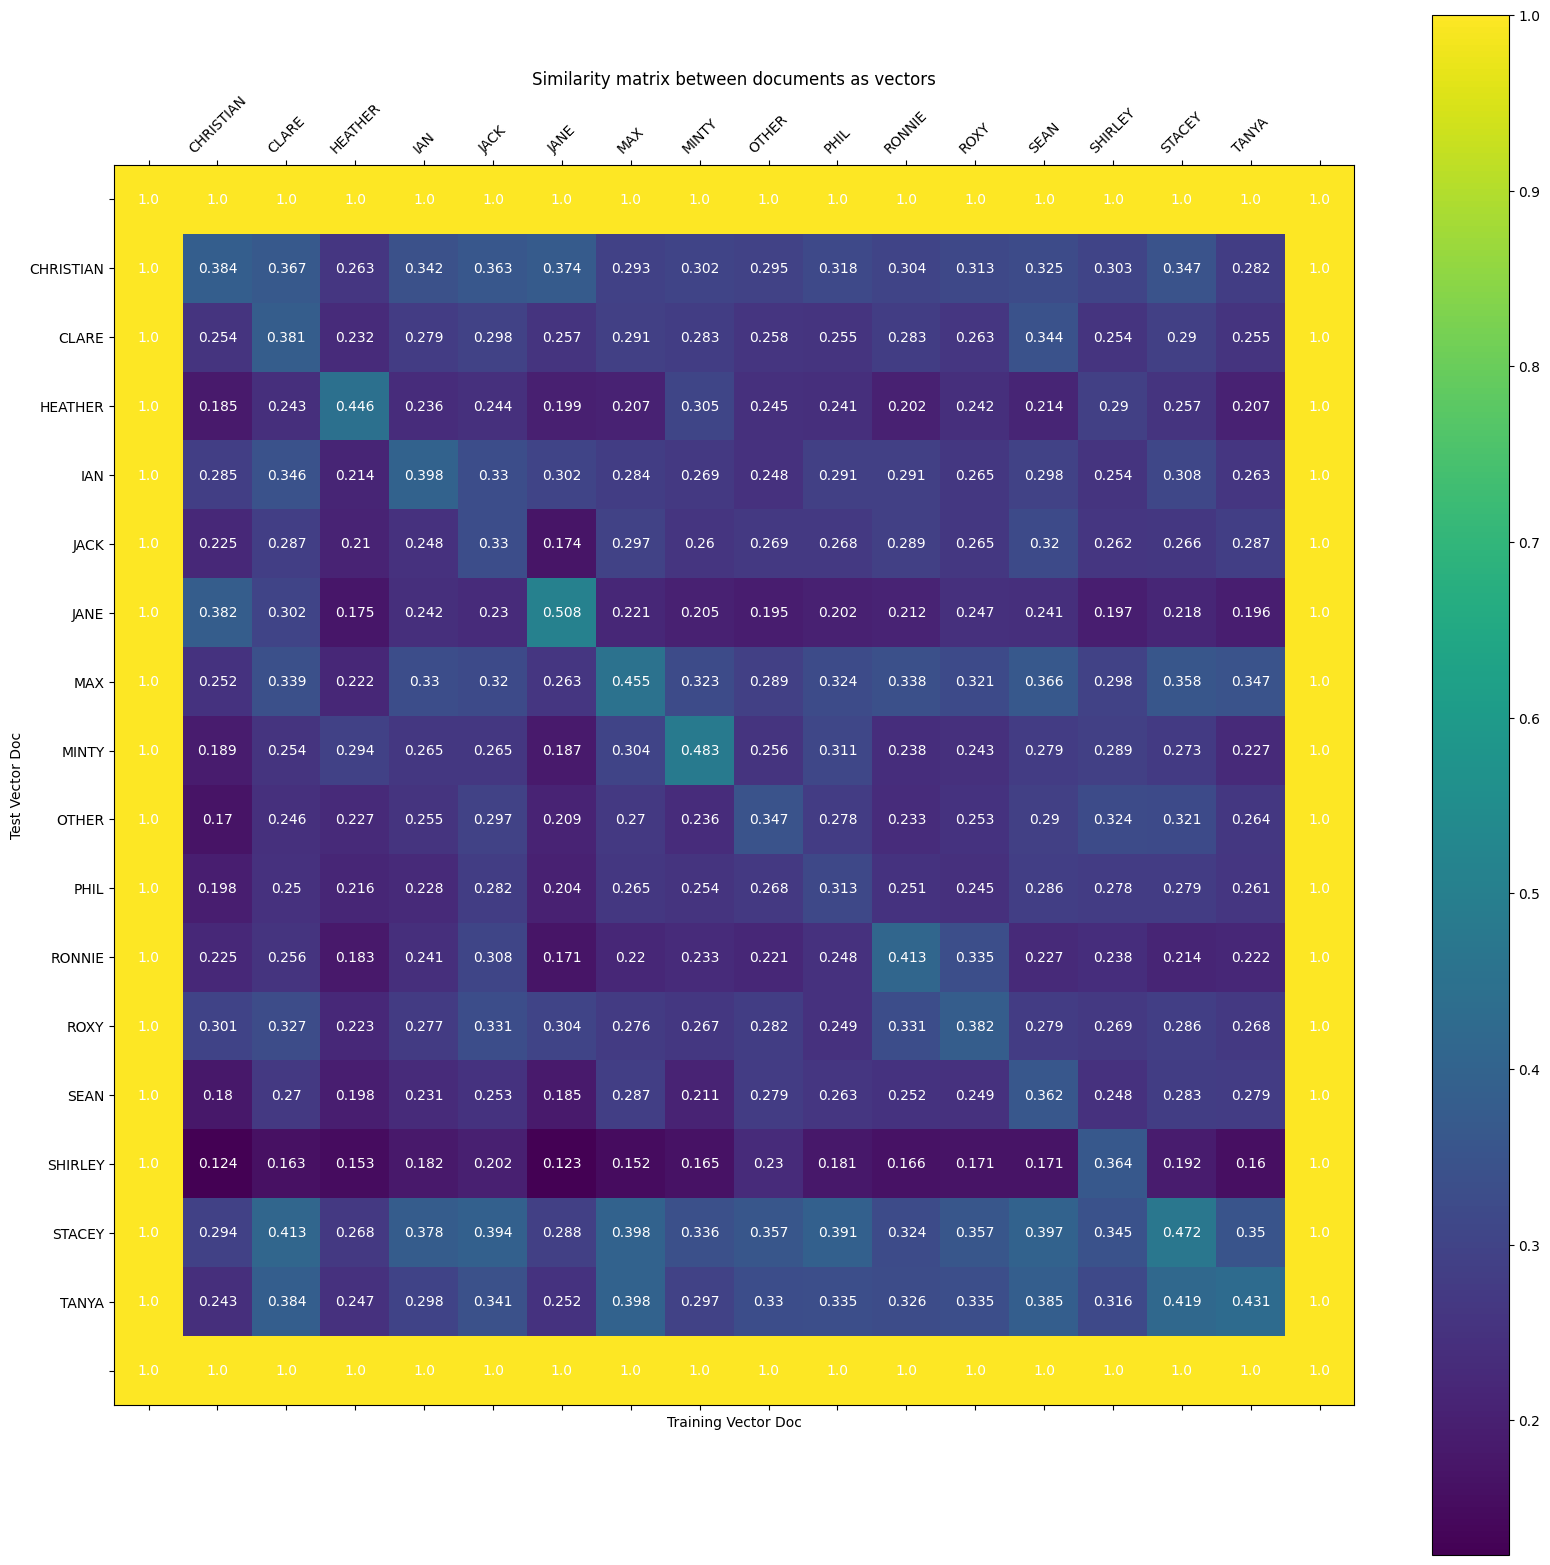

In [25]:
plot_heat_map_similarity(df)